# Train Target Model

In [18]:
import pandas as pd
import joblib
from joblib import Parallel, delayed
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
import optuna
from scipy import stats
from datetime import datetime
import numpy as np
import plotnine as gg
from Bio.SeqUtils import ProtParamData
from tqdm import tqdm
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt


from datasets import dataset_list, get_sg_groups_df
import target_featurization as ft
from core import (lollipop_plot,
                  setup_plots,
                  get_feature_df,
                  summary_legacy,
                  dependence_legacy)

In [2]:
setup_plots()

In [3]:
def lgbm_training_iteration(fold_df, train_index, features,
                            aa_seq_df, aa_features, aa_width,
                            protein_domain_df,
                            conservation_df, cons_small_width,
                            cons_large_width,
                            test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param features: list, features to us
    :param aa_seq_df: DataFrame
    :param aa_features: list
    :param aa_width: int
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param cons_small_width: int
    :param cons_large_width: int
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df, aa_features=aa_features,
                                                                      aa_width=aa_width,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df,
                                                                      cons_small_width=cons_small_width,
                                                                      cons_large_width=cons_large_width)
    X_train_val = train_feature_df[train_feature_cols]  # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df, aa_features=aa_features,
                                                                    aa_width=aa_width,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df,
                                                                    cons_small_width=cons_small_width,
                                                                    cons_large_width=cons_large_width)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['Residual Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(train_df, features, aa_seq_df, aa_features, aa_width,
                       protein_domain_df,
                       conservation_df, cons_small_width, cons_large_width):
    """Get objective function for training a lgbm model

    :param train_df: DataFrame
    :param features: list
    :param aa_seq_df: DataFrame
    :param aa_features: list
    :param aa_width: int
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param cons_small_width: int
    :param cons_large_width: int
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('regressor',
                           LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                         num_leaves=num_leaves,
                                         min_child_samples=min_child_samples))])
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (train_df, train_index, features,
                                          aa_seq_df, aa_features, aa_width,
                                          protein_domain_df,
                                          conservation_df,
                                          cons_small_width, cons_large_width,
                                          test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(train_df, train_df.dataset, train_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective


## Reading Data

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')
codon_map_df = pd.read_csv('../data/external/codon_map.csv')

## Loading Datasets

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        if ds.endogenous:
            train_data_list.append(ds)


sg_groups_df = get_sg_groups_df(train_data_list)
sg_groups_df = ft.add_target_columns(sg_groups_df)

Context sequences with multiple targets: 0


## Read Conservation Data

In [6]:
transcript_bases = list(sg_groups_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))

## Calculate Residuals

In [7]:
sg_df_residuals = sg_groups_df.copy()
seq_X = get_feature_df(sg_df_residuals)
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7808375117208222, 4.324227242326856e-205)
Doench2014_mouse     (0.7404292413640493, 1.379605215185353e-203)
Doench2016                              (0.6937302010352973, 0.0)
Munoz2016                               (0.7588083762083931, 0.0)
Wang2014            (0.7817756947398344, 1.9046619919131385e-211)
dtype: object

In [8]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']

In [9]:
## Training Model

In [10]:
features = ['position', 'aa', 'domain']
aa_features = ['Pos. Ind. 1mer', 'Hydrophobicity', 'Aromaticity',
               'Isoelectric Point', 'Secondary Structure']
aa_width = 16
cons_small_width = 4
cons_large_width = 32
n_trials = 50

In [11]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
objective = get_lgbm_objective(sg_df_residuals, features=features,
                               aa_seq_df=aa_seqs, aa_width=aa_width,
                               aa_features=aa_features, protein_domain_df=protein_domains,
                               conservation_df=conservation_df, cons_small_width=cons_small_width,
                               cons_large_width=cons_large_width)
start_time = datetime.now()
study.optimize(objective, n_trials=n_trials)
end_time = datetime.now()
difference = end_time - start_time
print("Number of finished trials: {}".format(len(study.trials)))
print("Training Time: " + str(difference))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Using optimal parameters, retrain model with full dataset
train_feature_df, train_feature_cols = ft.build_target_feature_df(sg_df_residuals,
                                                                  features=features,
                                                                  aa_seq_df=aa_seqs, aa_width=aa_width,
                                                                  aa_features=aa_features,
                                                                  protein_domain_df=protein_domains,
                                                                  conservation_df=conservation_df,
                                                                  cons_small_width=cons_small_width,
                                                                  cons_large_width=cons_large_width)
X_train_val = train_feature_df[train_feature_cols] # train and validation data
y_train_val = sg_df_residuals['Residual Activity']
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.1, random_state=7)
model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                  ('regressor', LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                   **trial.params))])
model.fit(X_train, y_train,
          regressor__early_stopping_rounds=20,
          regressor__eval_set=[(X_val, y_val)],
          regressor__verbose=1000)

[I 2021-07-28 13:42:12,817] A new study created in memory with name: no-name-f986f682-303b-49b1-b73f-62cbeb780729
[I 2021-07-28 13:42:31,214] Trial 0 finished with value: 0.06710119350285433 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.06710119350285433.
[I 2021-07-28 13:42:50,230] Trial 1 finished with value: 0.04464312278709157 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.06710119350285433.
[I 2021-07-28 13:43:10,950] Trial 2 finished with value: 0.038973980104876606 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.06710119350285433.
[I 2021-07-28 13:43:26,307] Trial 3 finished with value: 0.05188296994943993 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.06710119350285433.
[I 2021-07-28 13:43:45,521] Trial 4 finished with value: 0.045868630287143344 and parameters: {'num_leaves': 74, 'min_child_samples

Number of finished trials: 50
Training Time: 0:13:29.692694
Best trial:
  Value: 0.08051009060185739
  Params: 
    num_leaves: 8
    min_child_samples: 88
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.418337
[2000]	valid_0's l2: 0.414224
[3000]	valid_0's l2: 0.410215
Early stopping, best iteration is:
[3032]	valid_0's l2: 0.410151


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 LGBMRegressor(learning_rate=0.01, min_child_samples=88,
                               n_estimators=5000, n_jobs=8, num_leaves=8,
                               random_state=7))])

### Feature Importance

In [12]:
imputer = model['imputer']
regressor = model['regressor']
X_train_imputed = pd.DataFrame(imputer.transform(X_train),
                               columns=X_train.columns)

In [13]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train_imputed)

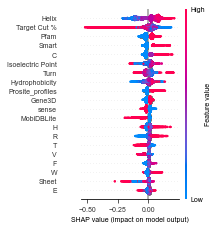

In [19]:
summary_legacy(shap_values, X_train, show=False, plot_size=(2.2, 3.5),
               point_size=5, text_size=None, color_bar_shrink=1,
               legend_aspect=30)
gpplot.savefig('../figures/target_shap_summary_plot.pdf', dpi=300)

In [15]:
feature_category_map = {'Target Cut %': 'Target Cut %',
                        'Orientation': 'sense',
                        'Domain': ['Pfam', 'PANTHER', 'HAMAP', 'SuperFamily', 'TIGRfam', 'ncoils', 'Gene3D',
                                   'Prosite_patterns', 'Seg', 'SignalP', 'TMHMM', 'MobiDBLite',
                                   'PIRSF', 'PRINTS', 'Smart', 'Prosite_profiles'],
                        'AA Physiochem': ['Hydrophobicity', 'Aromaticity',
                                          'Isoelectric Point', 'Helix', 'Turn', 'Sheet'],
                        'AA Pos. Ind. 1mer': '[A-Z]|\*'}
shap_df = pd.DataFrame(shap_values, columns=X_train_imputed.columns)
feature_category_list = []
for category, feature in feature_category_map.items():
    if type(feature) == str:
        matched_cols = shap_df.columns.str.fullmatch(feature)
    else: # list
        matched_cols = shap_df.columns.isin(feature)
    category_features = shap_df.columns[matched_cols]
    feature_category_list.extend([{'feature': f, 'category': category} for f in category_features])
feature_category_df = pd.DataFrame(feature_category_list)
shap_abs_importance = (shap_df.abs().mean(0)
                       .reset_index()
                       .rename({0: 'importance',
                                'index': 'feature'}, axis=1)
                       .sort_values('importance', ascending=False)
                       .merge(feature_category_df, how='inner', on='feature'))
category_importance = (shap_abs_importance.groupby('category')
                       .agg({'importance': 'sum'})
                       .reset_index()
                       .sort_values('importance', ascending=False))
category_importance['category'] = pd.Categorical(category_importance['category'],
                                                 categories=category_importance['category'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.2 x 2.4 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_shap_feature_category_importance.pdf


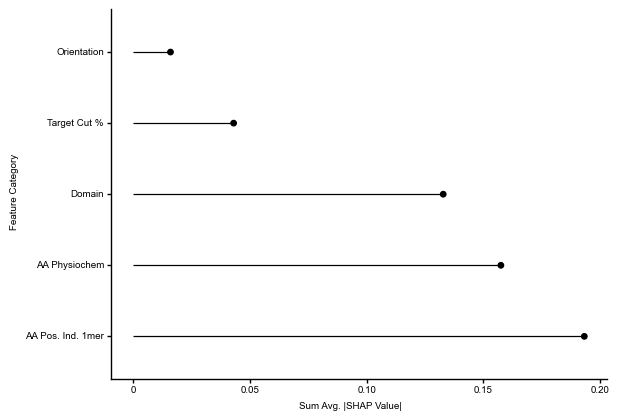

<ggplot: (8785165059822)>

In [20]:
g = lollipop_plot(category_importance, 'category', 'importance',
                  val_label='Sum Avg. |SHAP Value|', cat_label='Feature Category')
g.save('../figures/target_shap_feature_category_importance.pdf', width=2.2, height=2.4)
g


In [21]:
top_n = 20
top_features = shap_abs_importance.head(top_n).copy()
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.2 x 3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_shap_feature_importance.pdf


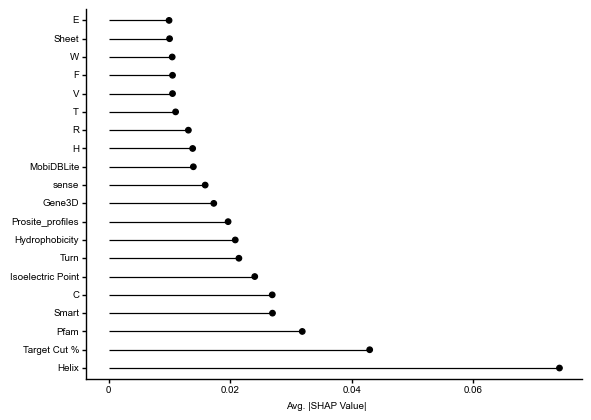

<ggplot: (8785180039144)>

In [23]:
g = lollipop_plot(top_features, 'feature', 'importance',
                  val_label='Avg. |SHAP Value|', cat_label='')
g.save('../figures/target_shap_feature_importance.pdf', width=2.2, height=3)
g

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


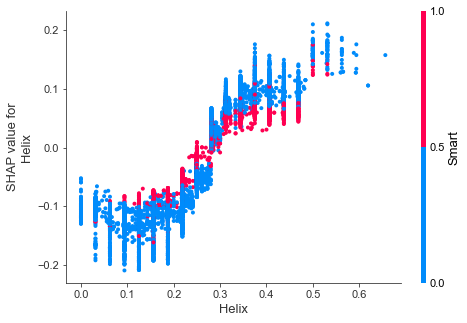

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


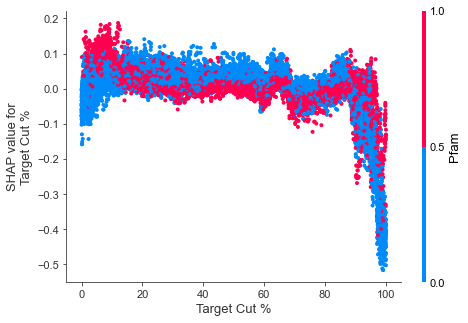

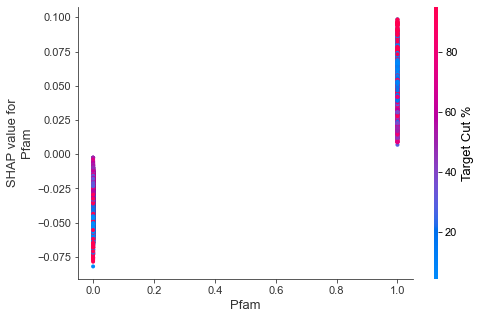

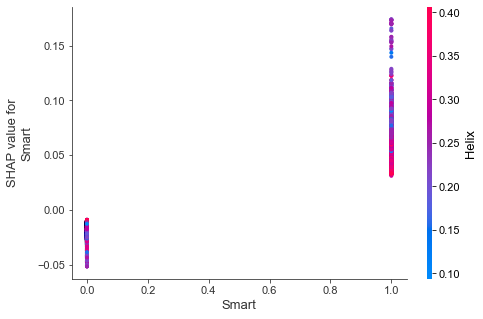

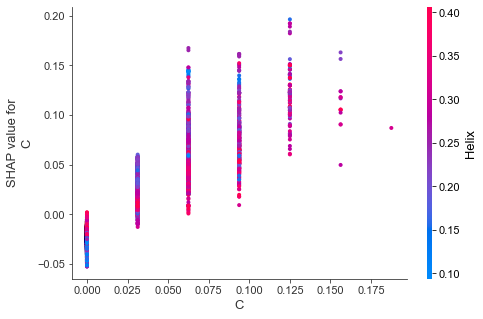

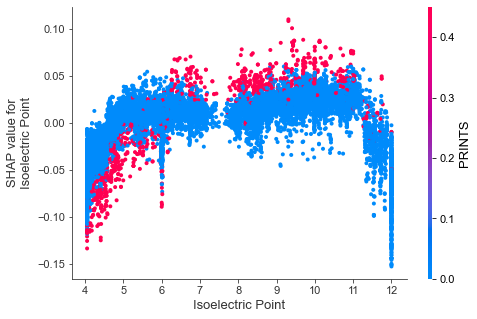

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


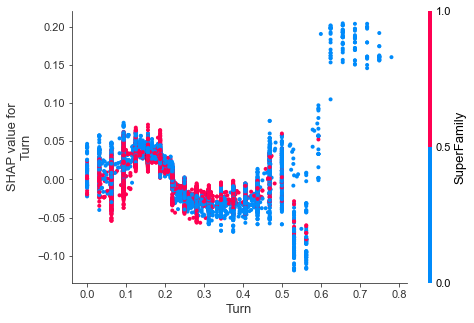

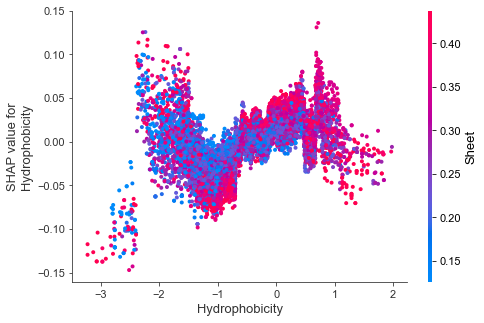

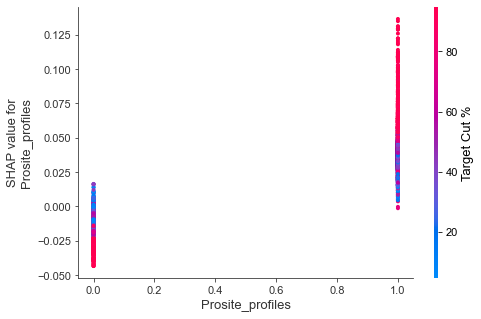

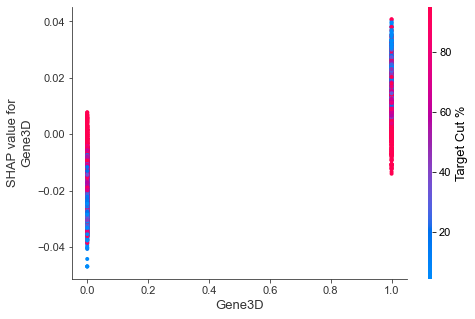

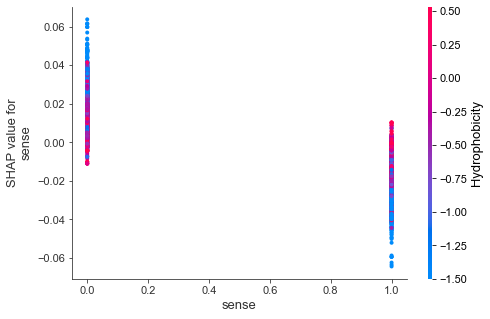

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


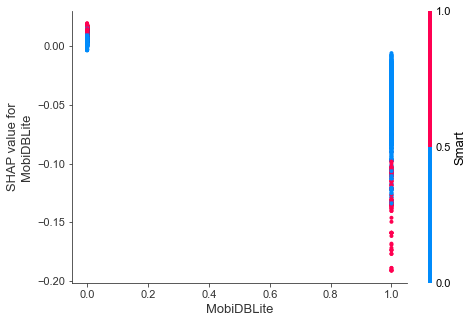

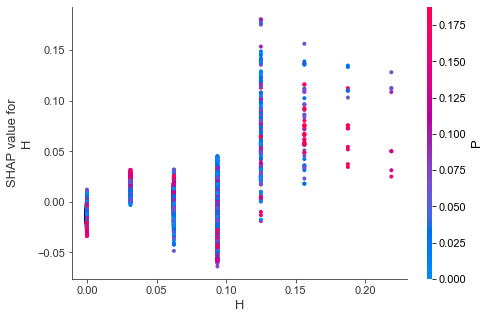

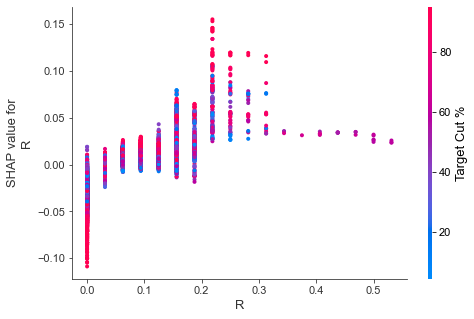

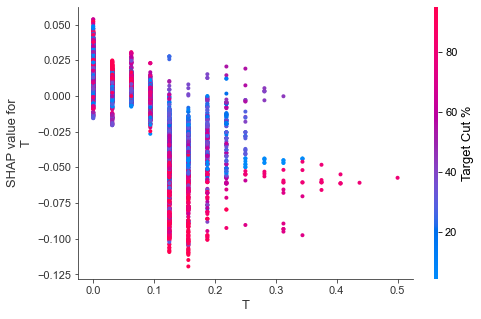

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


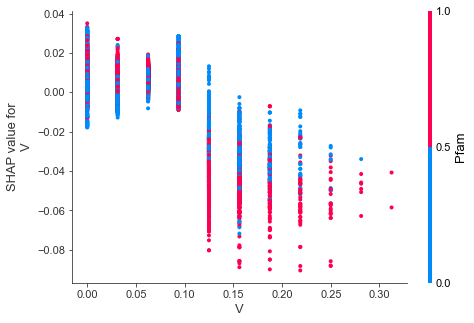

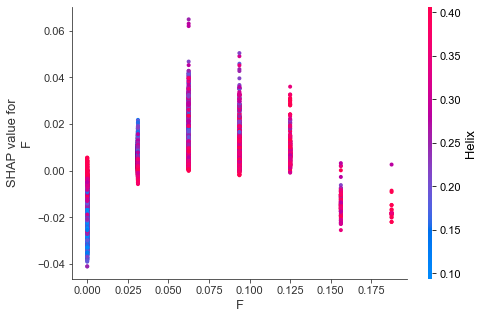

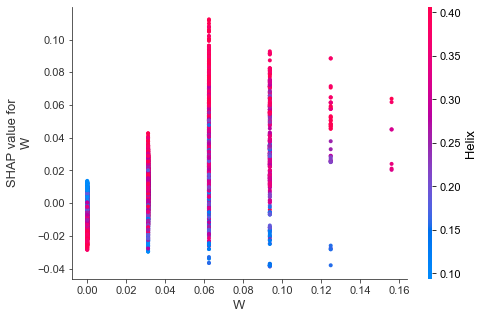

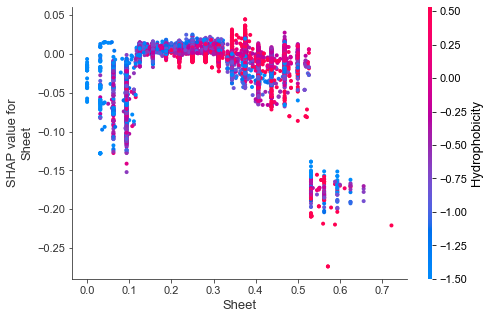

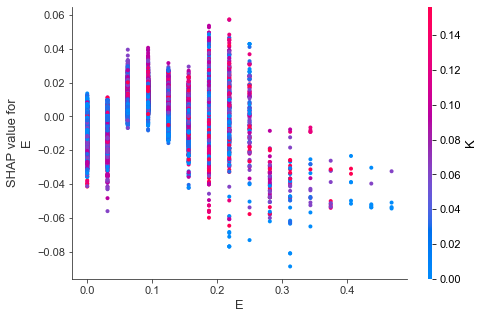

In [24]:
for feature in top_features['feature']:
    shap.dependence_plot(feature, shap_values, X_train_imputed)

In [25]:
interesting_features = ['Helix', 'Target Cut %', 'Pfam']

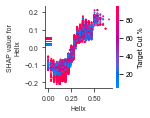

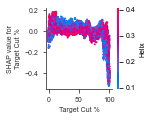

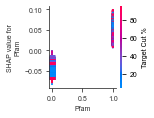

In [48]:
from importlib import reload
import core
reload(core)
from core import dependence_legacy

for ft in interesting_features:
    dependence_legacy(ft, shap_values, X_train, show=False, dot_size=4,
                      default_fig_size=(1.5, 1.5),
                      text_size=7, legend_aspect=30,
                      nan_width=1)
    gpplot.savefig('../figures/target_shap_' + ft + '_plot.pdf', dpi=300)

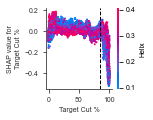

In [61]:
dependence_legacy('Target Cut %', shap_values, X_train, show=False, dot_size=4,
                      default_fig_size=(1.5, 1.5),
                      text_size=7, legend_aspect=30,
                      nan_width=1, interaction_index='Helix')
plt.axvline(x=85, linestyle='--',
            color='black', linewidth=1)
gpplot.savefig('../figures/target_shap_' + 'Target Cut %' + '_plot.pdf', dpi=300)

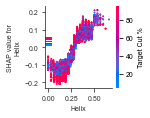

In [63]:
dependence_legacy('Helix', shap_values, X_train, show=False, dot_size=4,
                      default_fig_size=(1.5, 1.5),
                      text_size=7, legend_aspect=30,
                      nan_width=1, interaction_index='Target Cut %')
gpplot.savefig('../figures/target_shap_' + 'Helix' + '_plot.pdf', dpi=300)


## Amino Acid Importance

In [27]:
def get_shap_correlation(df):
    if (df['importance'].std() > 0) and (df['value'].std() > 0):
        return stats.pearsonr(df['importance'], df['value'])[0]
    else:
        return pd.NA


long_shap_df = (shap_df.reset_index()
                .rename({'index': 'train_index'}, axis=1)
                .melt(id_vars='train_index', var_name='feature',
                      value_name='importance'))
long_train_df = (X_train_imputed.reset_index(drop=True)
                 .reset_index()
                 .rename({'index': 'train_index'}, axis=1)
                 .melt(id_vars='train_index', var_name='feature',
                       value_name='value'))
long_shap_train_values = (long_shap_df.merge(long_train_df, how='inner',
                                             on=['train_index', 'feature']))
nonzero_shap_train_values = long_shap_train_values[long_shap_train_values['importance'] != 0]
shap_correlations = (nonzero_shap_train_values.groupby('feature')
                     .apply(lambda df: get_shap_correlation(df))
                     .reset_index(name='pearson_r'))
shap_correlations['direction'] = np.sign(shap_correlations['pearson_r'])
shap_directional_importance = (shap_abs_importance.merge(shap_correlations, how='inner',
                                                         on='feature'))
shap_directional_importance['directional_importance'] = (shap_directional_importance['direction'] *
                                                         shap_directional_importance['importance'])
shap_directional_importance = shap_directional_importance.sort_values('directional_importance')
aa_directional_importance = (shap_directional_importance[shap_directional_importance.category == 'AA Pos. Ind. 1mer']
                             .copy())
aa_directional_importance['feature'] = pd.Categorical(aa_directional_importance['feature'],
                                                      categories=aa_directional_importance['feature'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_model_aa_directional_importance.pdf


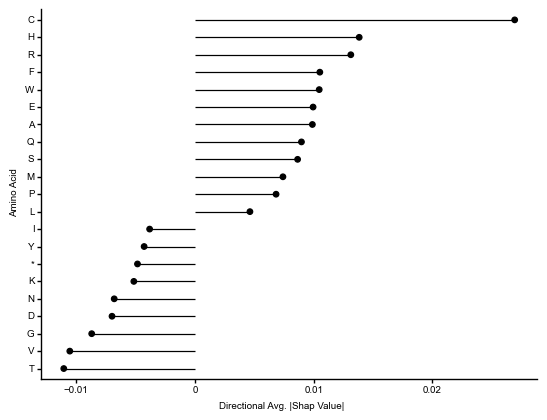

<ggplot: (8785137442955)>

In [29]:
g = lollipop_plot(aa_directional_importance, 'feature', 'directional_importance', cat_label='Amino Acid',
                  val_label='Directional Avg. |Shap Value|')
g.save('../figures/target_model_aa_directional_importance.pdf', width=3, height=3)
g

## Amino Acid Covariates

In [30]:
aa_nt_frac = (codon_map_df.groupby('Amino Acid')
              .agg(joined_codons = ('Codon', ''.join))
              .reset_index())
for nt in ['A', 'C', 'T', 'G']:
    aa_nt_frac[nt + ' frac.'] = aa_nt_frac['joined_codons'].str.count(nt)/aa_nt_frac['joined_codons'].str.len()


In [31]:
def make_physiochem_df(physio_dict, name):
    df = (pd.DataFrame.from_dict(physio_dict, orient='index')
          .reset_index()
          .rename({'index': 'Amino Acid',
                   0: name}, axis=1))
    return df

hydrophobicity_df = make_physiochem_df(ProtParamData.kd, 'hydrophobicity')
hydrophilicity_df = make_physiochem_df(ProtParamData.hw, 'hydrophilicity')
sa_df = make_physiochem_df(ProtParamData.em, 'surface accessibility')
ste_df = make_physiochem_df(ProtParamData.ja, 'surface transfer energy')
flex_df = make_physiochem_df(ProtParamData.Flex, 'flexibility')
all_physiochem_df = aa_nt_frac
for df in [hydrophobicity_df, hydrophilicity_df, sa_df, ste_df, flex_df]:
    all_physiochem_df = all_physiochem_df.merge(df, how='inner', on='Amino Acid')
all_physiochem_df = all_physiochem_df.merge(aa_directional_importance[['feature',
                                                                       'directional_importance']], how='left',
                                            left_on='Amino Acid', right_on='feature')

While we do see a relatively strong correlation with the fraction of G within an amino acid's codons,
95% confidence interval suggests this correlation is skewed closer to 0, largely driven by Glycine.

In [32]:
nboots = 1000
bootstrap_aa_cor_list = []
for i in tqdm(range(nboots)):
    resampled_pysiochem_df = (all_physiochem_df
                              .sample(frac=1, replace=True,
                                      random_state=i))
    correlations = resampled_pysiochem_df.corr().loc[:,'directional_importance'].rename(i)
    bootstrap_aa_cor_list.append(correlations)

pysiochem_core_ci = (pd.concat(bootstrap_aa_cor_list, axis=1)
                     .reset_index()
                     .rename({'index': 'property'}, axis=1)
                     .melt(id_vars='property', var_name='sample', value_name='pearson')
                     .groupby('property')
                     .agg(pearson_975 = ('pearson', lambda x: np.percentile(x, 97.5)),
                          pearson_025 = ('pearson', lambda x: np.percentile(x, 2.5)),
                          median_pearson = ('pearson', lambda x: np.percentile(x, 50)))
                     .reset_index()
                     .sort_values('median_pearson'))
pysiochem_core_ci['property'] = pd.Categorical(pysiochem_core_ci['property'],
                                               categories=pysiochem_core_ci['property'])

100%|██████████| 1000/1000 [00:00<00:00, 1284.53it/s]


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.3 x 2.3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_aa_physiochem_cor.pdf


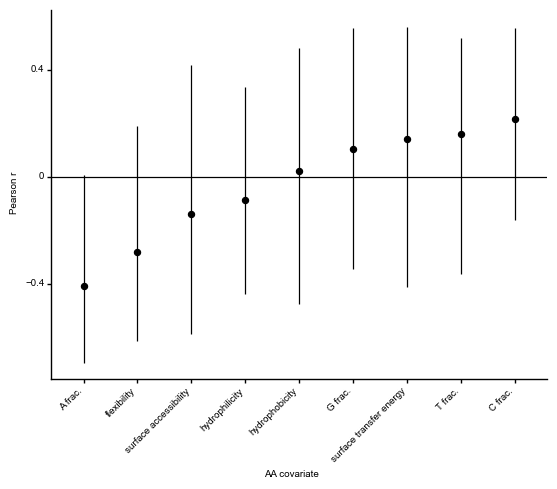

<ggplot: (8785112965620)>

In [64]:
g = (gg.ggplot(data=pysiochem_core_ci[pysiochem_core_ci['property'] != 'directional_importance']) +
     gg.aes(x='property', y='median_pearson',
            ymin='pearson_025', ymax='pearson_975') +
     gg.geom_pointrange() +
     gg.geom_hline(yintercept=0) +
     gg.theme(axis_text_x=gg.element_text(angle=45, hjust=1, vjust=1)) +
     gg.xlab('AA covariate') +
     gg.ylab('Pearson r'))
g.save('../figures/target_aa_physiochem_cor.pdf', width=2.3, height=2.3)
g

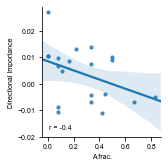

In [34]:
sns.lmplot(data=all_physiochem_df, x='A frac.', y='directional_importance', truncate=False,
           scatter_kws={'s': 10}, height=2.2)
gpplot.add_correlation(data=all_physiochem_df, x='A frac.', y='directional_importance',
                       loc='lower left')
plt.ylabel('Directional Importance')
gpplot.savefig('../figures/target_model_gfrac_cor.pdf')

## Output

In [35]:
joblib.dump(model, '../models/target_model.pkl')

['../models/target_model.pkl']